In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch

In [2]:
def load_data(path, batch_size, shuffle=True):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data = pd.read_csv(path)

    y = data['sales'].values
    x = data.drop(['sales'], axis = 1).values
    x = data.drop(["date"], axis=1).values

    x, y = to_batches(x, y, batch_size, shuffle)

    x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=0)

    transformer = preprocessing.PowerTransformer()
    y_train = transformer.fit_transform(y_train.reshape(-1,1))
    y_test = transformer.transform(y_test.reshape(-1,1))
    
    y_train = y_train.reshape(y_train.shape[0]//batch_size,batch_size,1)
    y_test = y_test.reshape(y_test.shape[0]//batch_size,batch_size,1)

    x_train = torch.tensor(x_train.astype(np.float32)).to(device)
    y_train = torch.tensor(y_train.astype(np.float32)).to(device)

    x_test = torch.tensor(x_test.astype(np.float32)).to(device)
    y_test = torch.tensor(y_test.astype(np.float32)).to(device)
    
    return x_train, x_test, y_train, y_test

def to_batches(x, y, batch_size, shuffle=True):

    if shuffle:

        indices = np.random.permutation(x.shape[0])
        x = x[indices]
        y = y[indices]

        n_batches = x.shape[0] // batch_size

        x = x[:n_batches * batch_size].reshape(n_batches, batch_size, x.shape[1])
        y = y[:n_batches * batch_size].reshape(n_batches, batch_size, 1)

    return x, y

x_train, x_test, y_train, y_test =  load_data("final_train.csv", batch_size=100, shuffle = True)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

torch.Size([24006, 100, 13]) torch.Size([6002, 100, 13]) torch.Size([24006, 100, 1]) torch.Size([6002, 100, 1])


In [3]:
x_train.shape

torch.Size([24006, 100, 13])

In [4]:
x_test.shape

torch.Size([6002, 100, 13])

In [5]:
from torch import nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [6]:
import matplotlib.pyplot as plt

Epoch: 2/200 	 Train Loss: 25.039836726628977, Test Loss: 1.3451815050210765
Epoch: 4/200 	 Train Loss: 16.96926439262068, Test Loss: 1.2499459139091578
Epoch: 6/200 	 Train Loss: 13.511630434436439, Test Loss: 0.7516100038710692
Epoch: 8/200 	 Train Loss: 11.370942010766694, Test Loss: 33.56961860103792
Epoch: 10/200 	 Train Loss: 9.295514810686656, Test Loss: 0.7186714950123456
Epoch: 12/200 	 Train Loss: 7.4928156317377805, Test Loss: 9.534908268857661
Epoch: 14/200 	 Train Loss: 5.0959462097145405, Test Loss: 0.7636206496937678
Epoch: 16/200 	 Train Loss: 2.8894183758218257, Test Loss: 1.5716736030475333
Epoch: 18/200 	 Train Loss: 0.9715516569303452, Test Loss: 0.9865897383363356
Epoch: 20/200 	 Train Loss: 0.9516231905025591, Test Loss: 0.9641983892889032
Epoch: 22/200 	 Train Loss: 0.3083253831692716, Test Loss: 0.12933825616194422
Epoch: 24/200 	 Train Loss: 0.13437424580967186, Test Loss: 0.06045514448449358
Epoch: 26/200 	 Train Loss: 0.08859448152357073, Test Loss: 0.0520254

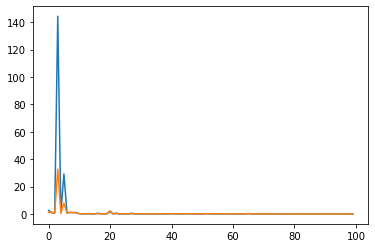

In [7]:
def train(model, x, y, x_val, y_val, optimizer, criterion, epochs, device):
    loss_train = []
    loss_test= []
    max_loss = 1000
    for epoch in range(epochs):
        losses = 0
        for i in range(x.shape[0]):
            model.to(device)

            optimizer.zero_grad()

            output = model.forward(x[i])
            #print(output.shape)
            #print(y[i].shape)
            loss = criterion(output, y[i])
            loss.backward()

            optimizer.step()

            losses += loss.item()

        if (epoch+1) % 2 == 0:
            loss_train.append(loss.item())
            test_losses = 0
            
            with torch.no_grad():
                model.eval()
                for j in range(x_val.shape[0]):
                    output = model.forward(x_val[j])
                    loss = criterion(output, y_val[j])
                    test_losses += loss.item()

            if test_losses/x_val.shape[0] < max_loss:
                torch.save(model.state_dict(), 'store_sales.pth')
                max_loss = test_losses/x_val.shape[0]

            loss_test.append(loss.item())
                
            model.train()
                
            print("Epoch: {}/{} \t Train Loss: {}, Test Loss: {}".format(epoch + 1, epochs, losses/x.shape[0], test_losses/x_val.shape[0]))
    
    plt.plot(loss_train)
    plt.plot(loss_test)
    plt.show()

model = MLP(13,[10,8], 1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = nn.MSELoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train(model, x_train, y_train, x_test, y_test, optimizer, criterion= criterion, epochs=200, device = device)


In [8]:
state_dict = torch.load('store_sales.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [36]:
prediction = model(x_test)

In [68]:
pred = prediction.detach().numpy().tolist()[0]

In [69]:
pred

[[-1.1424343585968018],
 [-1.1349318027496338],
 [1.5620806217193604],
 [0.8318207859992981],
 [0.8970120549201965],
 [0.8667457103729248],
 [-1.1496589183807373],
 [-1.1466670036315918],
 [-0.9171750545501709],
 [-1.1472373008728027],
 [-1.1397926807403564],
 [1.5620806217193604],
 [-0.9335222244262695],
 [-1.1294963359832764],
 [-0.9365365505218506],
 [-0.14554786682128906],
 [0.019988179206848145],
 [-1.1482136249542236],
 [0.86392742395401],
 [-0.9271471500396729],
 [0.8049936890602112],
 [-1.1614494323730469],
 [1.5069345235824585],
 [-0.06259870529174805],
 [0.9184452295303345],
 [0.8580378293991089],
 [1.1367546319961548],
 [-1.1513020992279053],
 [0.12317991256713867],
 [0.051805734634399414],
 [-1.1612884998321533],
 [-0.9098114967346191],
 [1.5620806217193604],
 [-0.16176724433898926],
 [1.140097975730896],
 [0.9092680215835571],
 [0.8625401854515076],
 [-0.7146966457366943],
 [-0.9114301204681396],
 [-1.147641897201538],
 [-0.7135012149810791],
 [-1.151435136795044],
 [1.562

In [70]:
y_pred = y_test.detach().numpy().tolist()[0]

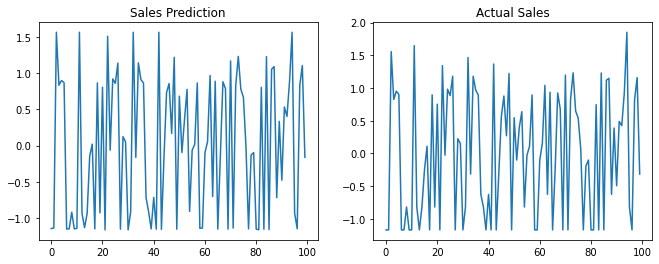

In [72]:
fig, ax = plt.subplots(1, 2,figsize=(11,4))
ax[0].set_title('Sales Prediction')
ax[0].plot(pred)
ax[1].set_title('Actual Sales')
ax[1].plot(y_pred)
plt.show()

In [61]:
pred

[[[-1.1424343585968018],
  [-1.1349318027496338],
  [1.5620806217193604],
  [0.8318207859992981],
  [0.8970120549201965],
  [0.8667457103729248],
  [-1.1496589183807373],
  [-1.1466670036315918],
  [-0.9171750545501709],
  [-1.1472373008728027],
  [-1.1397926807403564],
  [1.5620806217193604],
  [-0.9335222244262695],
  [-1.1294963359832764],
  [-0.9365365505218506],
  [-0.14554786682128906],
  [0.019988179206848145],
  [-1.1482136249542236],
  [0.86392742395401],
  [-0.9271471500396729],
  [0.8049936890602112],
  [-1.1614494323730469],
  [1.5069345235824585],
  [-0.06259870529174805],
  [0.9184452295303345],
  [0.8580378293991089],
  [1.1367546319961548],
  [-1.1513020992279053],
  [0.12317991256713867],
  [0.051805734634399414],
  [-1.1612884998321533],
  [-0.9098114967346191],
  [1.5620806217193604],
  [-0.16176724433898926],
  [1.140097975730896],
  [0.9092680215835571],
  [0.8625401854515076],
  [-0.7146966457366943],
  [-0.9114301204681396],
  [-1.147641897201538],
  [-0.71350121

In [55]:
pred_numpy

array([[[-1.1424344 ],
        [-1.1349318 ],
        [ 1.5620806 ],
        ...,
        [ 0.8290531 ],
        [ 1.1039078 ],
        [-0.16112661]],

       [[ 1.5620806 ],
        [ 1.2514061 ],
        [-1.145747  ],
        ...,
        [ 0.549247  ],
        [ 0.05257118],
        [-1.1571236 ]],

       [[-0.14665818],
        [-0.01152182],
        [ 0.7700542 ],
        ...,
        [ 1.5620806 ],
        [-0.11311448],
        [-0.9266405 ]],

       ...,

       [[ 0.06951118],
        [-1.1490018 ],
        [-0.02074015],
        ...,
        [-1.1442845 ],
        [-1.1506727 ],
        [-0.26575267]],

       [[ 0.98152447],
        [ 1.5620806 ],
        [ 1.5620806 ],
        ...,
        [-1.1551888 ],
        [ 0.9574806 ],
        [-0.13028717]],

       [[ 0.85877967],
        [ 1.5521684 ],
        [-1.1448038 ],
        ...,
        [ 0.97310805],
        [-1.1263385 ],
        [ 1.5620806 ]]], dtype=float32)

In [56]:
inverse_pred = np.exp(pred_numpy)

In [57]:
inverse_pred

array([[[0.31904143],
        [0.32144403],
        [4.768733  ],
        ...,
        [2.2911482 ],
        [3.0159287 ],
        [0.85118425]],

       [[4.768733  ],
        [3.4952543 ],
        [0.31798634],
        ...,
        [1.7319484 ],
        [1.0539776 ],
        [0.3143892 ]],

       [[0.86358917],
        [0.98854434],
        [2.1598833 ],
        ...,
        [4.768733  ],
        [0.89304835],
        [0.39588144]],

       ...,

       [[1.071984  ],
        [0.31695297],
        [0.9794735 ],
        ...,
        [0.3184517 ],
        [0.31642386],
        [0.7666287 ]],

       [[2.6685212 ],
        [4.768733  ],
        [4.768733  ],
        ...,
        [0.31499806],
        [2.6051247 ],
        [0.8778432 ]],

       [[2.3602786 ],
        [4.7216973 ],
        [0.31828636],
        ...,
        [2.6461558 ],
        [0.3242182 ],
        [4.768733  ]]], dtype=float32)